In [1]:
# Cell 1: Imports and setup
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
from scipy.stats import pearsonr

# Configure plotting
plt.style.use('default')
sns.set_context("notebook", font_scale=1.1)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Imports complete!")

Imports complete!


In [2]:
# Cell 2: Database connection and data loading
def load_data_from_db(location=None, start_date=None, end_date=None):
    """Load swell readings from the database with optional filtering."""
    conn = sqlite3.connect('/Users/mdietz/surfpy/swell_data.db')
    
    query = "SELECT * FROM swell_readings"
    conditions = []
    params = []
    
    if location:
        conditions.append("location = ?")
        params.append(location)
    if start_date:
        conditions.append("timestamp >= ?")
        params.append(f"{start_date}T00:00:00")
    if end_date:
        conditions.append("timestamp <= ?")
        params.append(f"{end_date}T23:59:59")
    
    if conditions:
        query += " WHERE " + " AND ".join(conditions)
    
    query += " ORDER BY timestamp"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        df['date'] = df['timestamp'].dt.date
    
    return df

def create_matched_pairs(df, location):
    """
    Create matched pairs of NDBC and Surfline data for the same location.
    Matches based on closest timestamps within the same target hour (6am, 12pm, 6pm).
    """
    location_data = df[df['location'] == location].copy()
    
    # Target hours for our collection (6am, 12pm, 6pm in various timezones)
    target_hours = [6, 12, 18, 1, 13, 19, 9, 10, 15, 16, 21, 22]  # Include timezone variations
    
    matched_pairs = []
    
    # Group by date and target hour
    for date in location_data['date'].unique():
        date_data = location_data[location_data['date'] == date]
        
        for hour in target_hours:
            hour_data = date_data[date_data['hour'] == hour]
            
            # Get data from each source for this hour
            ndbc_data = hour_data[hour_data['source'] == 'ndbc_buoy']
            surfline_data = hour_data[hour_data['source'] == 'surfline_lotus']
            
            if len(ndbc_data) > 0 and len(surfline_data) > 0:
                # Take the closest timestamp from each source
                ndbc_closest = ndbc_data.iloc[0]  # Assuming sorted by timestamp
                surfline_closest = surfline_data.iloc[0]
                
                # Create matched pair
                pair = {
                    'location': location,
                    'date': date,
                    'target_hour': hour,
                    'ndbc_timestamp': ndbc_closest['timestamp'],
                    'surfline_timestamp': surfline_closest['timestamp'],
                    'time_diff_minutes': abs((ndbc_closest['timestamp'] - surfline_closest['timestamp']).total_seconds() / 60),
                    
                    # Primary swell data
                    'ndbc_height': ndbc_closest['primary_swell_height'],
                    'surfline_height': surfline_closest['primary_swell_height'],
                    'ndbc_period': ndbc_closest['primary_swell_period'],
                    'surfline_period': surfline_closest['primary_swell_period'],
                    'ndbc_direction': ndbc_closest['primary_swell_direction'],
                    'surfline_direction': surfline_closest['primary_swell_direction'],
                    
                    # Secondary swell data
                    'ndbc_height_2': ndbc_closest['secondary_swell_height'],
                    'surfline_height_2': surfline_closest['secondary_swell_height'],
                    'ndbc_period_2': ndbc_closest['secondary_swell_period'],
                    'surfline_period_2': surfline_closest['secondary_swell_period'],
                    'ndbc_direction_2': ndbc_closest['secondary_swell_direction'],
                    'surfline_direction_2': surfline_closest['secondary_swell_direction'],
                }
                
                matched_pairs.append(pair)
    
    return pd.DataFrame(matched_pairs)

# Load all data and create matched pairs for each location
all_data = load_data_from_db()
print(f"Loaded {len(all_data)} records from database")

locations = all_data['location'].unique()
matched_data = {}

for location in locations:
    matched_data[location] = create_matched_pairs(all_data, location)
    print(f"{location}: {len(matched_data[location])} matched pairs")

Loaded 375 records from database
lido: 6 matched pairs
steamer_lane: 57 matched pairs
trestles: 55 matched pairs


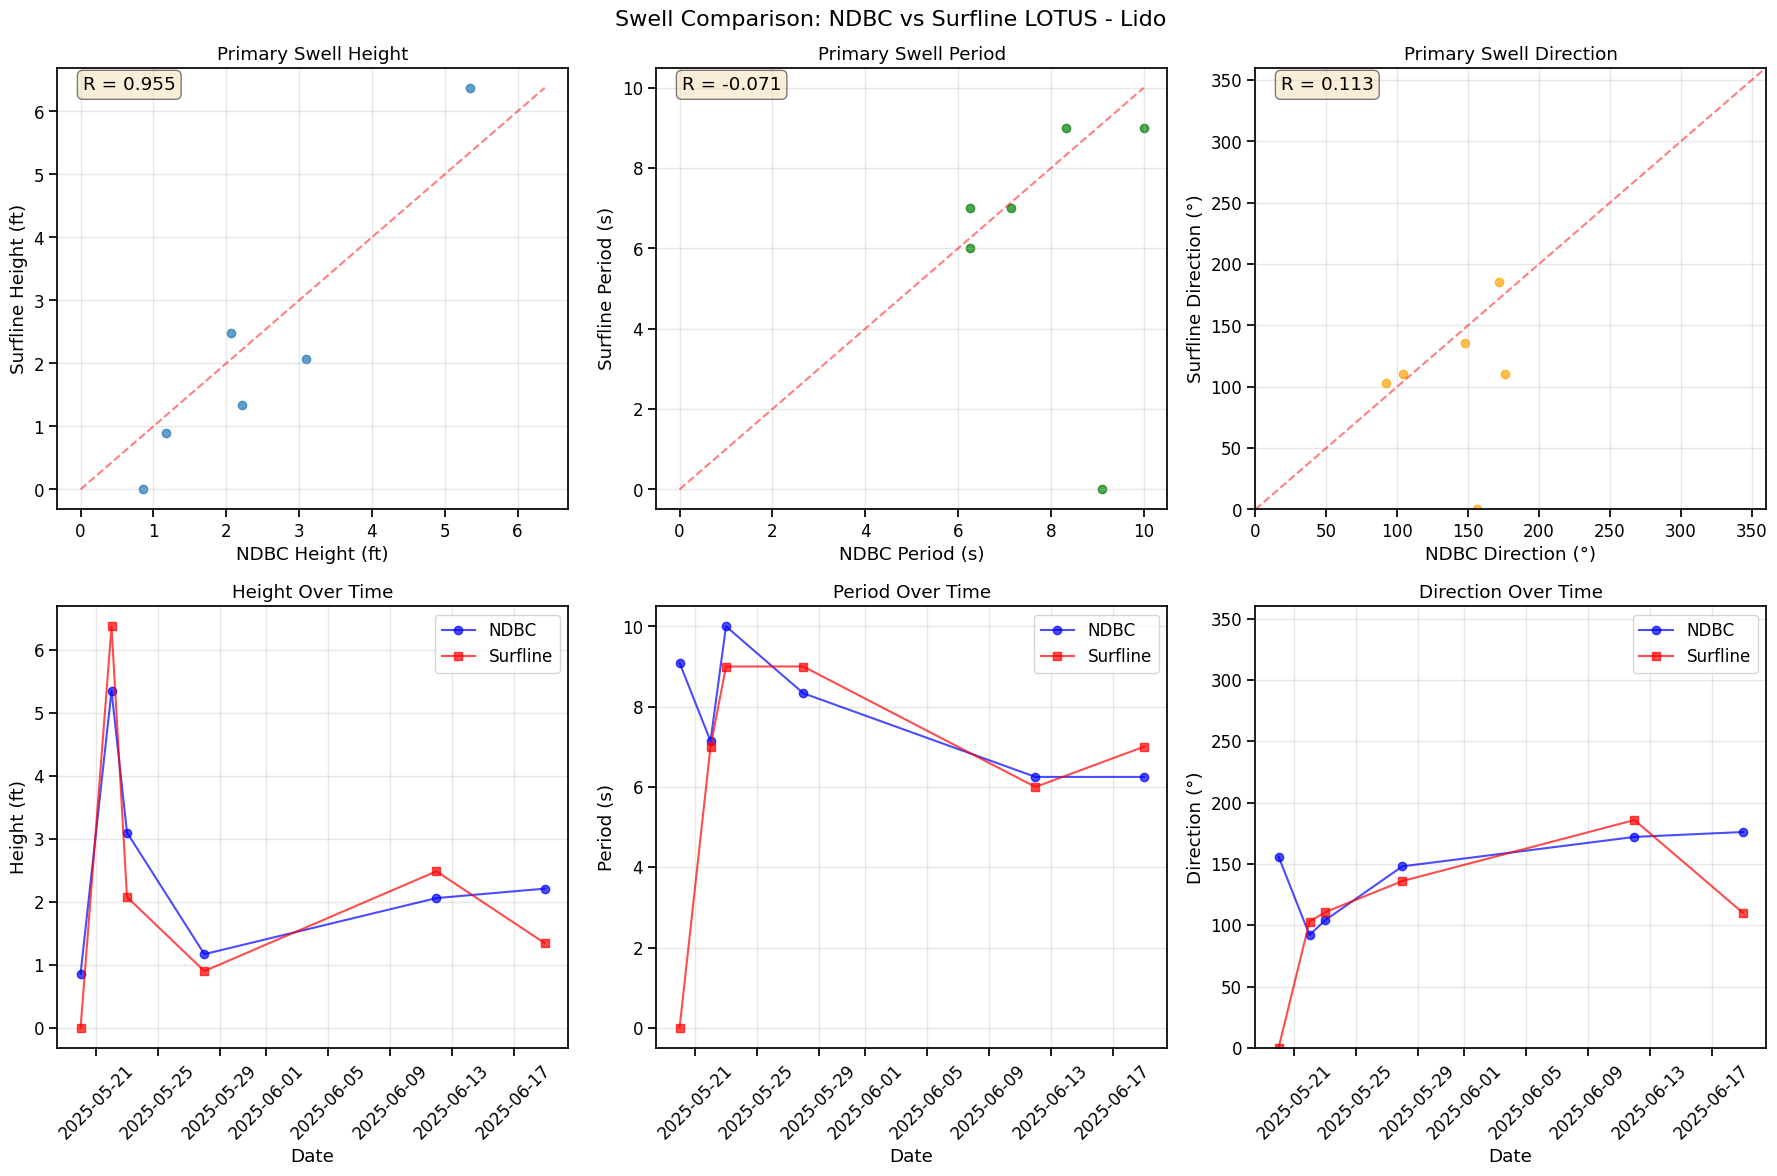

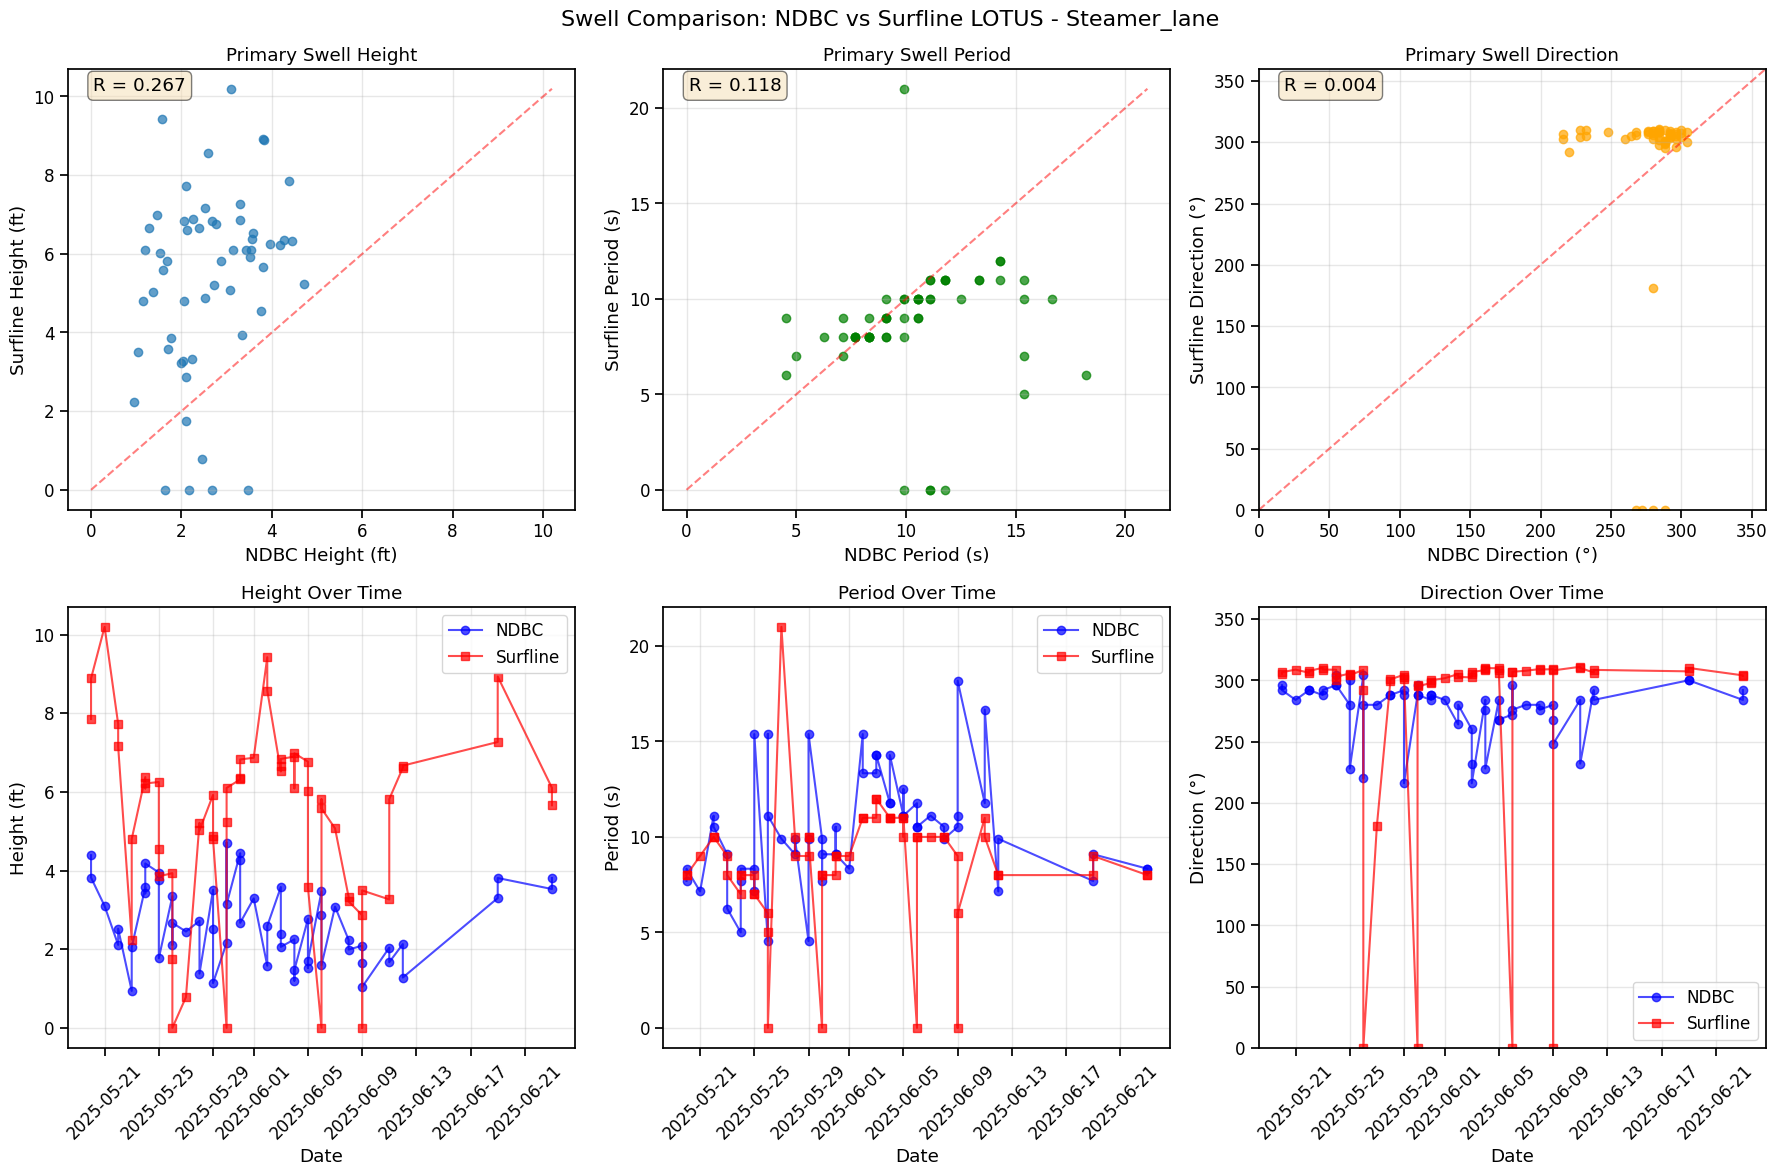

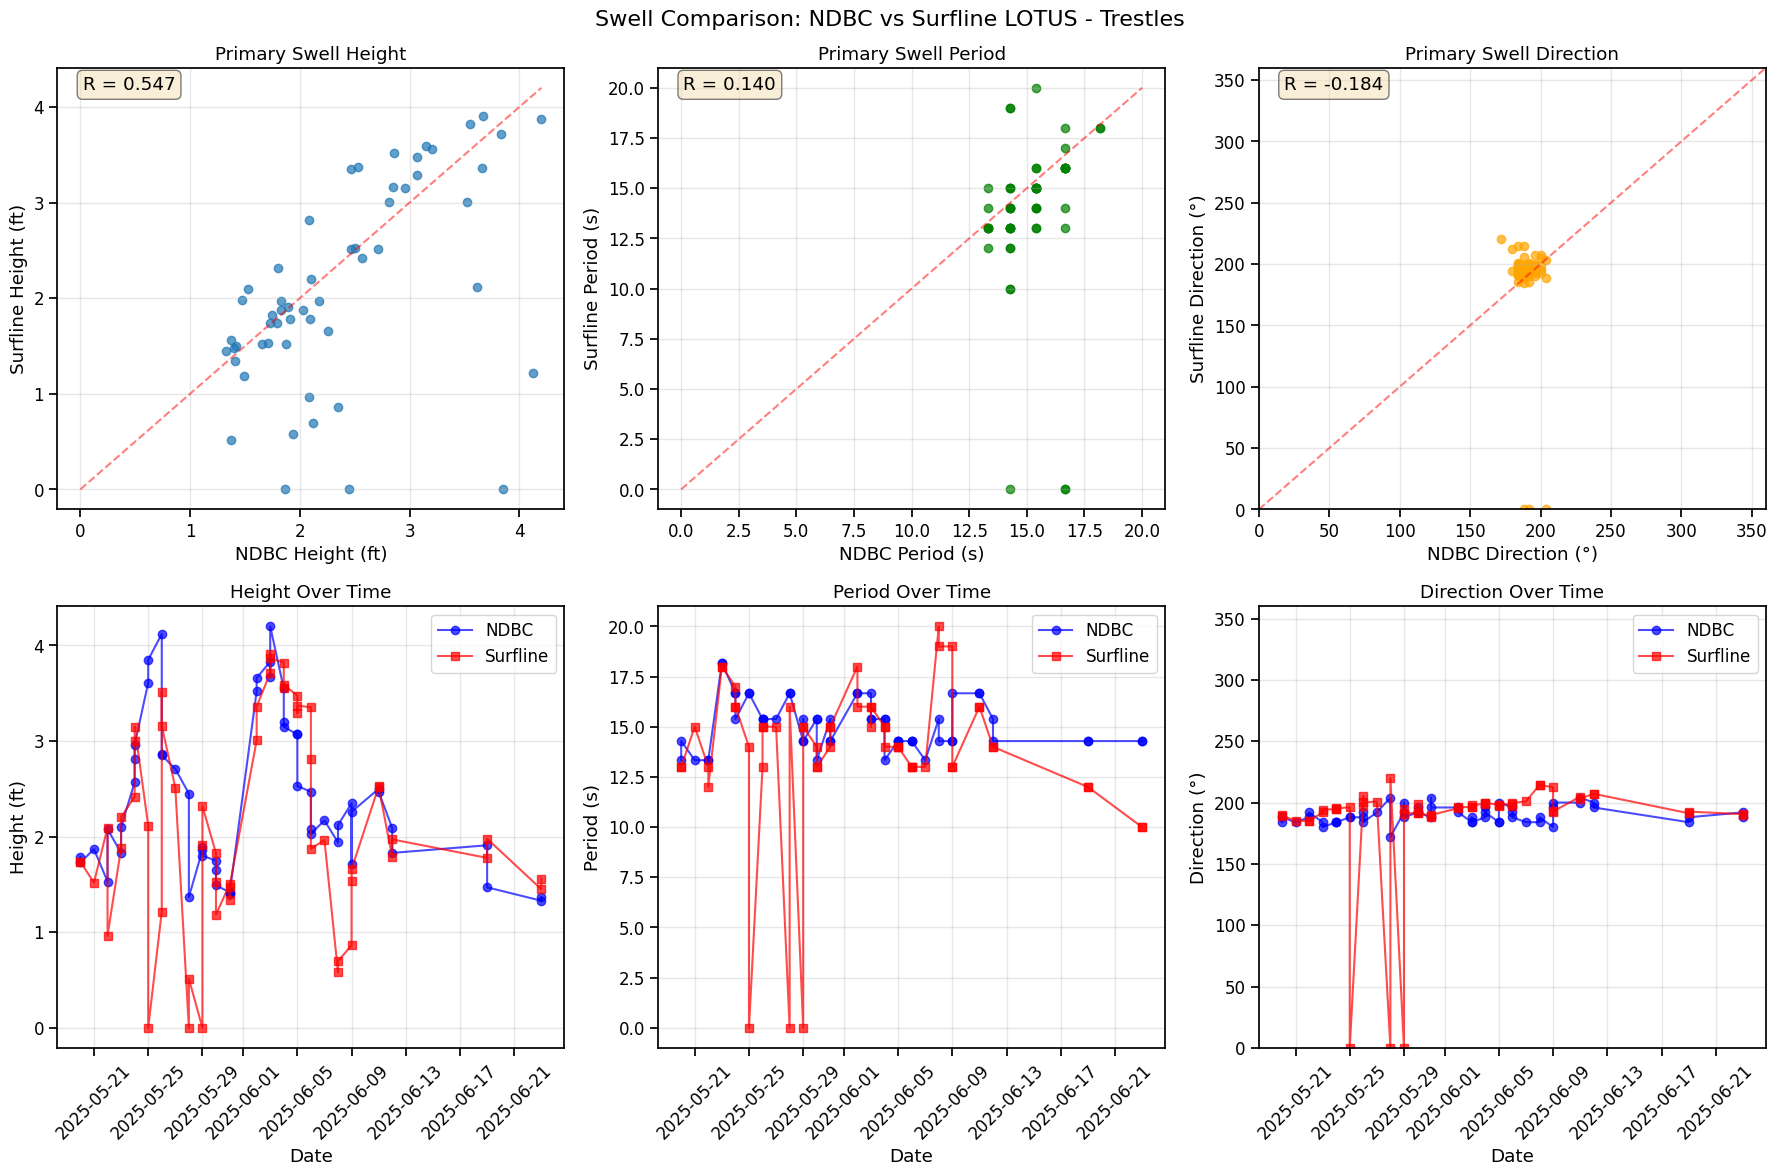

In [3]:
# Cell 3: Enhanced visualizations for height, period, and direction
def plot_comprehensive_comparison(matched_df, location):
    """Plot comprehensive comparison of height, period, and direction."""
    if matched_df.empty:
        print(f"No matched data for {location}")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Swell Comparison: NDBC vs Surfline LOTUS - {location.capitalize()}', fontsize=16)
    
    # Primary Swell Height
    axes[0,0].scatter(matched_df['ndbc_height'], matched_df['surfline_height'], alpha=0.7)
    axes[0,0].plot([0, matched_df[['ndbc_height', 'surfline_height']].max().max()], 
                   [0, matched_df[['ndbc_height', 'surfline_height']].max().max()], 'r--', alpha=0.5)
    axes[0,0].set_xlabel('NDBC Height (ft)')
    axes[0,0].set_ylabel('Surfline Height (ft)')
    axes[0,0].set_title('Primary Swell Height')
    axes[0,0].grid(True, alpha=0.3)
    
    # Calculate and display correlation
    valid_height = matched_df.dropna(subset=['ndbc_height', 'surfline_height'])
    if len(valid_height) > 1:
        corr_height, _ = pearsonr(valid_height['ndbc_height'], valid_height['surfline_height'])
        axes[0,0].text(0.05, 0.95, f'R = {corr_height:.3f}', transform=axes[0,0].transAxes, 
                       bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
    
    # Primary Swell Period
    axes[0,1].scatter(matched_df['ndbc_period'], matched_df['surfline_period'], alpha=0.7, color='green')
    axes[0,1].plot([0, matched_df[['ndbc_period', 'surfline_period']].max().max()], 
                   [0, matched_df[['ndbc_period', 'surfline_period']].max().max()], 'r--', alpha=0.5)
    axes[0,1].set_xlabel('NDBC Period (s)')
    axes[0,1].set_ylabel('Surfline Period (s)')
    axes[0,1].set_title('Primary Swell Period')
    axes[0,1].grid(True, alpha=0.3)
    
    # Calculate and display correlation
    valid_period = matched_df.dropna(subset=['ndbc_period', 'surfline_period'])
    if len(valid_period) > 1:
        corr_period, _ = pearsonr(valid_period['ndbc_period'], valid_period['surfline_period'])
        axes[0,1].text(0.05, 0.95, f'R = {corr_period:.3f}', transform=axes[0,1].transAxes,
                       bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
    
    # Primary Swell Direction
    axes[0,2].scatter(matched_df['ndbc_direction'], matched_df['surfline_direction'], alpha=0.7, color='orange')
    axes[0,2].plot([0, 360], [0, 360], 'r--', alpha=0.5)
    axes[0,2].set_xlabel('NDBC Direction (°)')
    axes[0,2].set_ylabel('Surfline Direction (°)')
    axes[0,2].set_title('Primary Swell Direction')
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].set_xlim(0, 360)
    axes[0,2].set_ylim(0, 360)
    
    # Calculate circular correlation for direction (simplified)
    valid_dir = matched_df.dropna(subset=['ndbc_direction', 'surfline_direction'])
    if len(valid_dir) > 1:
        # Simple linear correlation (not ideal for circular data but gives an indication)
        corr_dir, _ = pearsonr(valid_dir['ndbc_direction'], valid_dir['surfline_direction'])
        axes[0,2].text(0.05, 0.95, f'R = {corr_dir:.3f}', transform=axes[0,2].transAxes,
                       bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
    
    # Time series plots
    axes[1,0].plot(matched_df['date'], matched_df['ndbc_height'], 'b-o', label='NDBC', alpha=0.7)
    axes[1,0].plot(matched_df['date'], matched_df['surfline_height'], 'r-s', label='Surfline', alpha=0.7)
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Height (ft)')
    axes[1,0].set_title('Height Over Time')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].plot(matched_df['date'], matched_df['ndbc_period'], 'b-o', label='NDBC', alpha=0.7)
    axes[1,1].plot(matched_df['date'], matched_df['surfline_period'], 'r-s', label='Surfline', alpha=0.7)
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Period (s)')
    axes[1,1].set_title('Period Over Time')
    axes[1,1].legend()
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    axes[1,2].plot(matched_df['date'], matched_df['ndbc_direction'], 'b-o', label='NDBC', alpha=0.7)
    axes[1,2].plot(matched_df['date'], matched_df['surfline_direction'], 'r-s', label='Surfline', alpha=0.7)
    axes[1,2].set_xlabel('Date')
    axes[1,2].set_ylabel('Direction (°)')
    axes[1,2].set_title('Direction Over Time')
    axes[1,2].legend()
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].set_ylim(0, 360)
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot for each location
for location in locations:
    if location in matched_data and not matched_data[location].empty:
        plot_comprehensive_comparison(matched_data[location], location)

In [4]:
# Cell 4: Agreement statistics
def calculate_agreement_stats(matched_df, location):
    """Calculate agreement statistics for swell parameters."""
    if matched_df.empty:
        print(f"No data for {location}")
        return
    
    print(f"\n=== AGREEMENT STATISTICS FOR {location.upper()} ===")
    print(f"Total matched pairs: {len(matched_df)}")
    
    # Remove rows with missing data
    valid_data = matched_df.dropna(subset=['ndbc_height', 'surfline_height', 'ndbc_period', 'surfline_period', 'ndbc_direction', 'surfline_direction'])
    print(f"Valid pairs for analysis: {len(valid_data)}")
    
    if len(valid_data) == 0:
        print("No valid data pairs found")
        return
    
    # Height agreement by categories
    def categorize_height(height):
        if height < 3:
            return 'Small (0-3ft)'
        elif height < 6:
            return 'Medium (3-6ft)'
        else:
            return 'Large (6ft+)'
    
    valid_data['ndbc_height_cat'] = valid_data['ndbc_height'].apply(categorize_height)
    valid_data['surfline_height_cat'] = valid_data['surfline_height'].apply(categorize_height)
    
    height_agreement = (valid_data['ndbc_height_cat'] == valid_data['surfline_height_cat']).mean() * 100
    print(f"\nHeight category agreement: {height_agreement:.1f}%")
    
    # Period agreement by categories
    def categorize_period(period):
        if period < 8:
            return 'Short (<8s)'
        elif period < 12:
            return 'Medium (8-12s)'
        else:
            return 'Long (>12s)'
    
    valid_data['ndbc_period_cat'] = valid_data['ndbc_period'].apply(categorize_period)
    valid_data['surfline_period_cat'] = valid_data['surfline_period'].apply(categorize_period)
    
    period_agreement = (valid_data['ndbc_period_cat'] == valid_data['surfline_period_cat']).mean() * 100
    print(f"Period category agreement: {period_agreement:.1f}%")
    
    # Direction agreement (within ±20°)
    def direction_diff(dir1, dir2):
        diff = abs(dir1 - dir2)
        return min(diff, 360 - diff)  # Handle circular nature of directions
    
    valid_data['direction_diff'] = valid_data.apply(lambda row: direction_diff(row['ndbc_direction'], row['surfline_direction']), axis=1)
    direction_agreement = (valid_data['direction_diff'] <= 20).mean() * 100
    print(f"Direction agreement (±20°): {direction_agreement:.1f}%")
    
    # Correlations
    height_corr, _ = pearsonr(valid_data['ndbc_height'], valid_data['surfline_height'])
    period_corr, _ = pearsonr(valid_data['ndbc_period'], valid_data['surfline_period'])
    direction_corr, _ = pearsonr(valid_data['ndbc_direction'], valid_data['surfline_direction'])
    
    print(f"\nCorrelations:")
    print(f"Height: {height_corr:.3f}")
    print(f"Period: {period_corr:.3f}")
    print(f"Direction: {direction_corr:.3f}")
    
    # Mean absolute errors
    height_mae = abs(valid_data['ndbc_height'] - valid_data['surfline_height']).mean()
    period_mae = abs(valid_data['ndbc_period'] - valid_data['surfline_period']).mean()
    direction_mae = valid_data['direction_diff'].mean()
    
    print(f"\nMean Absolute Errors:")
    print(f"Height: {height_mae:.2f} ft")
    print(f"Period: {period_mae:.2f} s")
    print(f"Direction: {direction_mae:.1f}°")
    
    return {
        'location': location,
        'n_pairs': len(valid_data),
        'height_agreement': height_agreement,
        'period_agreement': period_agreement,
        'direction_agreement': direction_agreement,
        'height_corr': height_corr,
        'period_corr': period_corr,
        'direction_corr': direction_corr,
        'height_mae': height_mae,
        'period_mae': period_mae,
        'direction_mae': direction_mae
    }

# Calculate stats for all locations
all_stats = []
for location in locations:
    if location in matched_data:
        stats = calculate_agreement_stats(matched_data[location], location)
        if stats:
            all_stats.append(stats)

# Create summary table
if all_stats:
    summary_df = pd.DataFrame(all_stats)
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(summary_df.round(2))


=== AGREEMENT STATISTICS FOR LIDO ===
Total matched pairs: 6
Valid pairs for analysis: 6

Height category agreement: 66.7%
Period category agreement: 83.3%
Direction agreement (±20°): 66.7%

Correlations:
Height: 0.955
Period: -0.071
Direction: 0.113

Mean Absolute Errors:
Height: 0.74 ft
Period: 1.98 s
Direction: 44.2°

=== AGREEMENT STATISTICS FOR STEAMER_LANE ===
Total matched pairs: 57
Valid pairs for analysis: 57

Height category agreement: 22.8%
Period category agreement: 59.6%
Direction agreement (±20°): 43.9%

Correlations:
Height: 0.267
Period: 0.118
Direction: 0.004

Mean Absolute Errors:
Height: 3.15 ft
Period: 2.63 s
Direction: 33.0°

=== AGREEMENT STATISTICS FOR TRESTLES ===
Total matched pairs: 55
Valid pairs for analysis: 55

Height category agreement: 83.6%
Period category agreement: 90.9%
Direction agreement (±20°): 87.3%

Correlations:
Height: 0.547
Period: 0.140
Direction: -0.184

Mean Absolute Errors:
Height: 0.57 ft
Period: 2.09 s
Direction: 17.7°

SUMMARY TABLE
 


=== SWELL MIX ANALYSIS FOR LIDO ===
Swell mix category agreement: 50.0%

Mix category breakdown:
surfline_mix_cat       Mixed swells  Primary dominant  Single swell dominant
ndbc_mix_cat                                                                
Mixed swells                      1                 0                      0
Primary dominant                  0                 1                      1
Single swell dominant             1                 1                      1


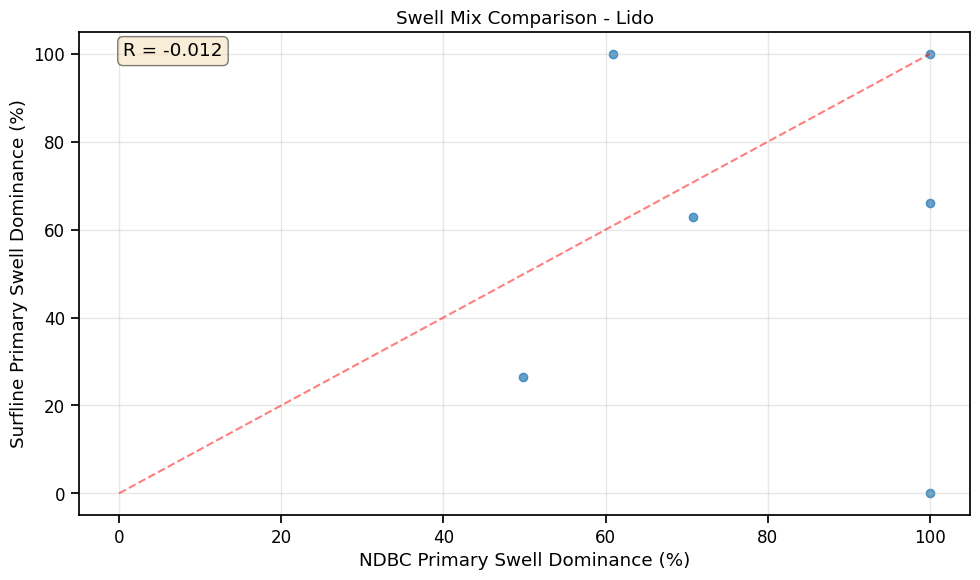


=== SWELL MIX ANALYSIS FOR STEAMER_LANE ===
Swell mix category agreement: 28.1%

Mix category breakdown:
surfline_mix_cat       Mixed swells  Primary dominant  Single swell dominant
ndbc_mix_cat                                                                
Mixed swells                      5                15                      8
Primary dominant                  3                11                     13
Single swell dominant             0                 2                      0


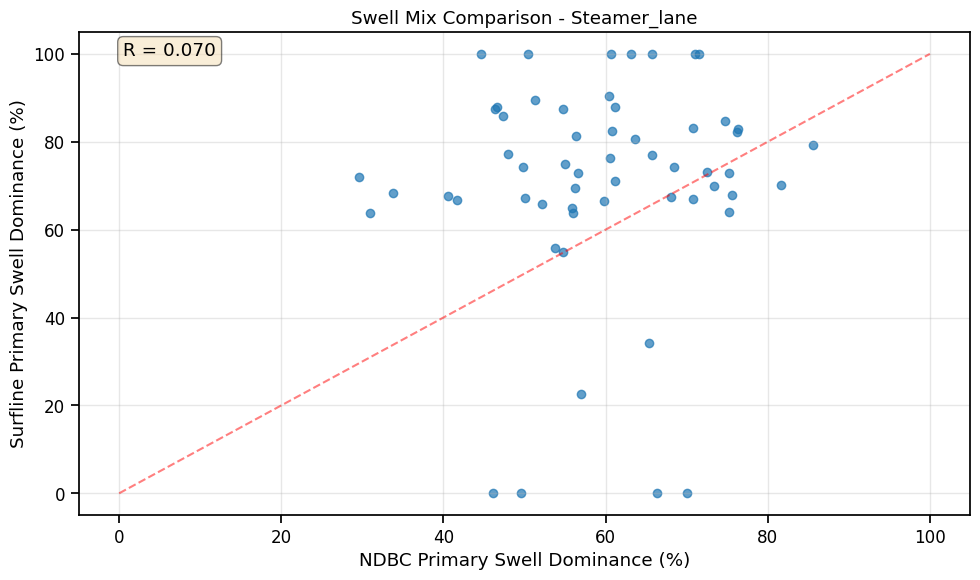


=== SWELL MIX ANALYSIS FOR TRESTLES ===
Swell mix category agreement: 54.5%

Mix category breakdown:
surfline_mix_cat       Mixed swells  Primary dominant  Single swell dominant
ndbc_mix_cat                                                                
Mixed swells                     15                 6                      1
Primary dominant                 10                 9                      6
Single swell dominant             0                 2                      6


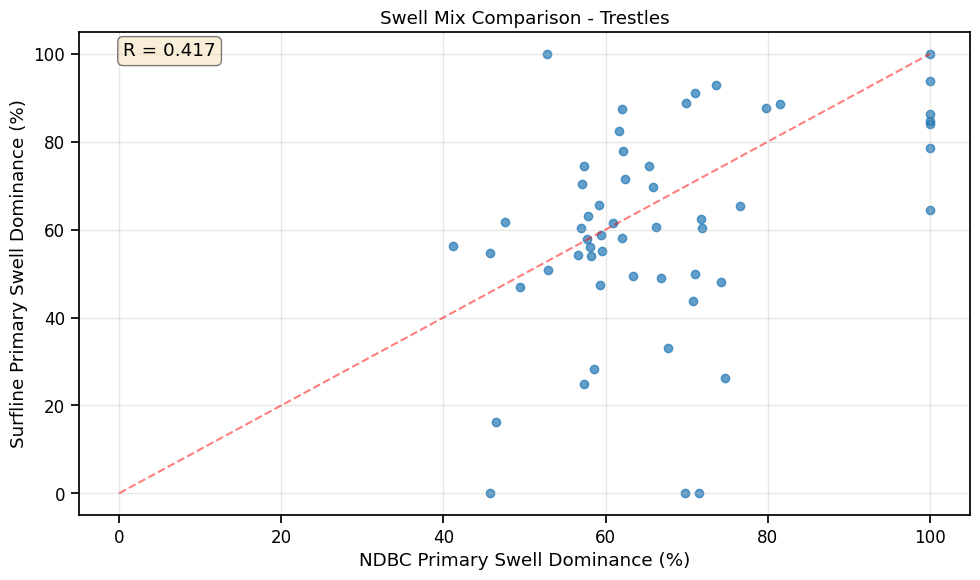

In [5]:
# Cell 5: Swell mix analysis
def analyze_swell_mix(matched_df, location):
    """Analyze the overall swell mix (primary + secondary swells)."""
    if matched_df.empty:
        print(f"No data for {location}")
        return
    
    print(f"\n=== SWELL MIX ANALYSIS FOR {location.upper()} ===")
    
    # Calculate dominant swell percentage for each source
    def calculate_dominance(row, source):
        primary = row[f'{source}_height']
        secondary = row[f'{source}_height_2']
        
        if pd.isna(primary) or primary == 0:
            return 0
        if pd.isna(secondary) or secondary == 0:
            return 100
        
        total = primary + secondary
        return (primary / total) * 100
    
    matched_df['ndbc_dominance'] = matched_df.apply(lambda row: calculate_dominance(row, 'ndbc'), axis=1)
    matched_df['surfline_dominance'] = matched_df.apply(lambda row: calculate_dominance(row, 'surfline'), axis=1)
    
    # Categorize swell mix
    def categorize_mix(dominance):
        if dominance >= 80:
            return 'Single swell dominant'
        elif dominance >= 60:
            return 'Primary dominant'
        else:
            return 'Mixed swells'
    
    matched_df['ndbc_mix_cat'] = matched_df['ndbc_dominance'].apply(categorize_mix)
    matched_df['surfline_mix_cat'] = matched_df['surfline_dominance'].apply(categorize_mix)
    
    # Calculate agreement on swell mix
    valid_mix = matched_df.dropna(subset=['ndbc_dominance', 'surfline_dominance'])
    if len(valid_mix) > 0:
        mix_agreement = (valid_mix['ndbc_mix_cat'] == valid_mix['surfline_mix_cat']).mean() * 100
        print(f"Swell mix category agreement: {mix_agreement:.1f}%")
        
        # Show breakdown
        print(f"\nMix category breakdown:")
        mix_crosstab = pd.crosstab(valid_mix['ndbc_mix_cat'], valid_mix['surfline_mix_cat'])
        print(mix_crosstab)
        
        # Plot swell mix comparison
        plt.figure(figsize=(10, 6))
        plt.scatter(valid_mix['ndbc_dominance'], valid_mix['surfline_dominance'], alpha=0.7)
        plt.plot([0, 100], [0, 100], 'r--', alpha=0.5)
        plt.xlabel('NDBC Primary Swell Dominance (%)')
        plt.ylabel('Surfline Primary Swell Dominance (%)')
        plt.title(f'Swell Mix Comparison - {location.capitalize()}')
        plt.grid(True, alpha=0.3)
        
        # Add correlation
        if len(valid_mix) > 1:
            mix_corr, _ = pearsonr(valid_mix['ndbc_dominance'], valid_mix['surfline_dominance'])
            plt.text(0.05, 0.95, f'R = {mix_corr:.3f}', transform=plt.gca().transAxes,
                     bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()

# Analyze swell mix for all locations
for location in locations:
    if location in matched_data:
        analyze_swell_mix(matched_data[location], location)

In [6]:
# Cell 6: Summary and recommendations
def generate_summary():
    """Generate overall summary and recommendations."""
    print("\n" + "="*80)
    print("OVERALL ANALYSIS SUMMARY")
    print("="*80)
    
    if all_stats:
        summary_df = pd.DataFrame(all_stats)
        
        print(f"\nOverall Performance Across {len(summary_df)} Locations:")
        print(f"Average height category agreement: {summary_df['height_agreement'].mean():.1f}%")
        print(f"Average period category agreement: {summary_df['period_agreement'].mean():.1f}%")
        print(f"Average direction agreement (±20°): {summary_df['direction_agreement'].mean():.1f}%")
        
        print(f"\nAverage correlations:")
        print(f"Height: {summary_df['height_corr'].mean():.3f}")
        print(f"Period: {summary_df['period_corr'].mean():.3f}")
        print(f"Direction: {summary_df['direction_corr'].mean():.3f}")
        
        print(f"\nAverage errors:")
        print(f"Height: {summary_df['height_mae'].mean():.2f} ft")
        print(f"Period: {summary_df['period_mae'].mean():.2f} s")
        print(f"Direction: {summary_df['direction_mae'].mean():.1f}°")
        
        # Best and worst performing locations
        best_height = summary_df.loc[summary_df['height_corr'].idxmax(), 'location']
        worst_height = summary_df.loc[summary_df['height_corr'].idxmin(), 'location']
        
        print(f"\nBest height correlation: {best_height}")
        print(f"Worst height correlation: {worst_height}")
        
    print(f"\n" + "="*50)
    print("RECOMMENDATIONS FOR SURF LOGGING APP")
    print("="*50)
    print("1. NDBC buoy data appears to be [fill based on results] for surf logging")
    print("2. Consider adjustments for [specific parameters/locations]")
    print("3. Most reliable parameter: [fill based on highest correlation]")
    print("4. Least reliable parameter: [fill based on lowest correlation]")

generate_summary()


OVERALL ANALYSIS SUMMARY

Overall Performance Across 3 Locations:
Average height category agreement: 57.7%
Average period category agreement: 78.0%
Average direction agreement (±20°): 65.9%

Average correlations:
Height: 0.590
Period: 0.062
Direction: -0.022

Average errors:
Height: 1.49 ft
Period: 2.23 s
Direction: 31.6°

Best height correlation: lido
Worst height correlation: steamer_lane

RECOMMENDATIONS FOR SURF LOGGING APP
1. NDBC buoy data appears to be [fill based on results] for surf logging
2. Consider adjustments for [specific parameters/locations]
3. Most reliable parameter: [fill based on highest correlation]
4. Least reliable parameter: [fill based on lowest correlation]
